## Task

In this HW, you will create a conditional variational autoencoder for CIFAR-10 dataset.

In contitional VAEs, you also use the class label as input to both encoder and decoders. And during generation you use the class label as input to decoder to generate an image for that particular class.

Your task is to load the CIFAR10 dataset. Create and train a conditional VAE on that dataset. Finally, as evaluation generate and show 10 pictures for each of the classes.


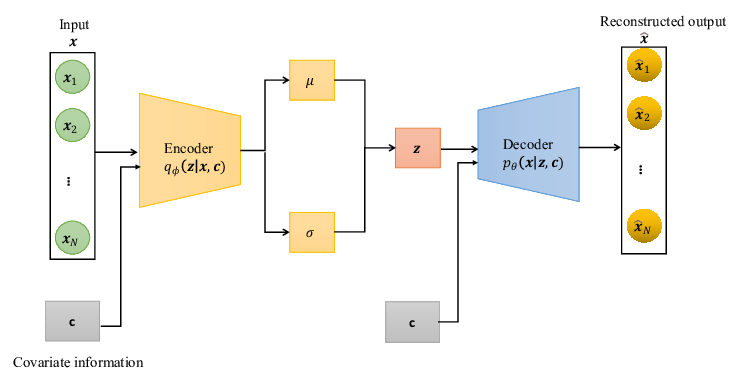

[Image Source](https://www.researchgate.net/figure/Structure-of-the-conditional-variational-autoencoder-CVAE_fig2_365190062)

In [ ]:
!pip install torchinfo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from IPython.display import clear_output
from torchinfo import summary
clear_output()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 256
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
Trainset, Valset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.8), len(train_dataset)-int(len(train_dataset)*0.8)])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Valset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 41246168.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## Model Archeticture


In [ ]:
class ImageGenerator(nn.Module):
    def __init__(self, z_dim):
        super(ImageGenerator, self).__init__()
        self.z_dim = z_dim
        self.dropout_rate = 0.1

        def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2),
                nn.MaxPool2d(2, 2)
            )

        self.encoder = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            conv_block(128, 256)
        )

        self.fc_mu = nn.Sequential(
            nn.Linear(256 * 2 * 2 + 10, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(self.dropout_rate),
            nn.Linear(512, z_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(self.dropout_rate)
        )

        self.fc_logvar = nn.Sequential(
            nn.Linear(256 * 2 * 2 + 10, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(self.dropout_rate),
            nn.Linear(512, z_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(self.dropout_rate)
        )

        self.decoder_input = nn.Sequential(
            nn.Linear(z_dim + 10, 256 * 2 * 2),
            nn.Dropout(self.dropout_rate),
            nn.ReLU()
        )


        def deconv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )

        self.decoder = nn.Sequential(
            deconv_block(256, 128),
            deconv_block(128, 64),
            deconv_block(64, 32),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

        self.mu = None
        self.logvar = None

    def encode(self, x, c):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  
        x = torch.cat([x, c], dim=1)
        self.mu = self.fc_mu(x)
        self.logvar = self.fc_logvar(x)
        return self.mu, self.logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z = torch.cat([z, c], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 256, 2, 2)
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        self.mu, self.logvar = self.encode(x, c)
        z = self.reparameterize(self.mu, self.logvar)
        return self.decode(z, c), self.mu, self.logvar

    # def generate(self, c, z=None):
    #   z = self.reparameterize(self.mu, self.logvar)
    #   return self.decode(z, c)

### Sanity check

In [ ]:
latent_dim = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data, labels = next(iter(train_loader))
data, labels = data.to(device), labels.to(device)
# One-hot encode the labels
c = torch.zeros(data.size(0), 10, device=device)
c.scatter_(1, labels.unsqueeze(1), 1)
model = ImageGenerator(latent_dim).to(device)
recon_batch, mu, logvar = model(data, c)
print(recon_batch.shape)

torch.Size([256, 3, 32, 32])


### Training loop

In [ ]:
num_epochs = 50
learning_rate = 1e-3
KLD_WEIGHT = 0.00012
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Loss function for Variational Auto Encoder
def loss_fn(y_true, y_pred, mu, logvar):

  # The total loss will consist of two parts: Reconstruction loss and KL divergence

  # Reconstruction Loss is simply mean squared error of gt and prediction like in autoencoders.
  reconstruction_loss = nn.functional.mse_loss(y_pred, y_true)

  # The second part of loss is the KL Divergence between the approximate posterior q(z|x) and latent prior p(z) assuming them to be normal distributions.
  kld_loss =   torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

  loss = (1-KLD_WEIGHT)*reconstruction_loss + KLD_WEIGHT*kld_loss
  return loss

In [ ]:
train_losses = []
val_losses = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (imgs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        imgs, labels = imgs.to(device), labels.to(device)

        c = torch.zeros(imgs.size(0), 10, device=device)
        c.scatter_(1, labels.unsqueeze(1), 1)


        reconstructed_imgs, mu, logvar = model(imgs, c)
        loss = loss_fn(imgs, reconstructed_imgs, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    epoch_loss = train_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (imgs, labels) in tqdm(enumerate(val_loader), total=len(val_loader)):
            imgs, labels = imgs.to(device), labels.to(device)

            c = torch.zeros(imgs.size(0), 10, device=device)
            c.scatter_(1, labels.unsqueeze(1), 1)

            reconstructed_imgs, mu, logvar = model(imgs, c)
            loss = loss_fn(imgs, reconstructed_imgs, mu, logvar)
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"\nEpoch: {epoch+1}/{num_epochs} Training loss: {epoch_loss:.4f} \t Validation loss: {epoch_val_loss}")

100%|██████████| 40/40 [00:03<00:00, 12.62it/s]



Epoch: 1/50 Training loss: 0.1542 	 Validation loss: 0.1190945278853178


100%|██████████| 40/40 [00:03<00:00, 12.81it/s]



Epoch: 2/50 Training loss: 0.1106 	 Validation loss: 0.10291020143777133


100%|██████████| 40/40 [00:03<00:00, 12.26it/s]



Epoch: 3/50 Training loss: 0.0984 	 Validation loss: 0.0929853405803442


100%|██████████| 40/40 [00:03<00:00, 10.57it/s]



Epoch: 4/50 Training loss: 0.0939 	 Validation loss: 0.08798200860619546


100%|██████████| 40/40 [00:04<00:00,  9.75it/s]



Epoch: 5/50 Training loss: 0.0904 	 Validation loss: 0.08538845200091601


100%|██████████| 40/40 [00:03<00:00, 10.42it/s]



Epoch: 6/50 Training loss: 0.0887 	 Validation loss: 0.08675630260258912


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]



Epoch: 7/50 Training loss: 0.0870 	 Validation loss: 0.08160992376506329


100%|██████████| 40/40 [00:03<00:00, 12.68it/s]



Epoch: 8/50 Training loss: 0.0850 	 Validation loss: 0.07961719110608101


100%|██████████| 40/40 [00:03<00:00, 12.84it/s]



Epoch: 9/50 Training loss: 0.0831 	 Validation loss: 0.0766907000914216


100%|██████████| 40/40 [00:03<00:00, 12.78it/s]



Epoch: 10/50 Training loss: 0.0820 	 Validation loss: 0.07610426731407642


100%|██████████| 40/40 [00:03<00:00, 12.96it/s]



Epoch: 11/50 Training loss: 0.0810 	 Validation loss: 0.07563821282237768


100%|██████████| 40/40 [00:03<00:00, 12.62it/s]



Epoch: 12/50 Training loss: 0.0803 	 Validation loss: 0.07378232683986426


100%|██████████| 40/40 [00:03<00:00, 12.55it/s]



Epoch: 13/50 Training loss: 0.0797 	 Validation loss: 0.07321239020675421


100%|██████████| 40/40 [00:03<00:00, 11.93it/s]



Epoch: 14/50 Training loss: 0.0791 	 Validation loss: 0.07208993155509233


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]



Epoch: 15/50 Training loss: 0.0782 	 Validation loss: 0.07123500369489193


100%|██████████| 40/40 [00:04<00:00, 10.00it/s]



Epoch: 16/50 Training loss: 0.0775 	 Validation loss: 0.0710352085530758


100%|██████████| 40/40 [00:03<00:00, 10.12it/s]



Epoch: 17/50 Training loss: 0.0771 	 Validation loss: 0.07064285036176443


100%|██████████| 40/40 [00:03<00:00, 11.70it/s]



Epoch: 18/50 Training loss: 0.0766 	 Validation loss: 0.0696372827515006


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]



Epoch: 19/50 Training loss: 0.0760 	 Validation loss: 0.06894515603780746


100%|██████████| 40/40 [00:03<00:00, 12.83it/s]



Epoch: 20/50 Training loss: 0.0756 	 Validation loss: 0.06820335201919078


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]



Epoch: 21/50 Training loss: 0.0752 	 Validation loss: 0.06819740906357766


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]



Epoch: 22/50 Training loss: 0.0748 	 Validation loss: 0.06806939877569676


100%|██████████| 40/40 [00:03<00:00, 12.88it/s]



Epoch: 23/50 Training loss: 0.0745 	 Validation loss: 0.06680229119956493


100%|██████████| 40/40 [00:03<00:00, 12.83it/s]



Epoch: 24/50 Training loss: 0.0741 	 Validation loss: 0.06673717461526393


100%|██████████| 40/40 [00:03<00:00, 12.65it/s]



Epoch: 25/50 Training loss: 0.0739 	 Validation loss: 0.0660750987008214


100%|██████████| 40/40 [00:03<00:00, 13.01it/s]



Epoch: 26/50 Training loss: 0.0735 	 Validation loss: 0.0662050111219287


100%|██████████| 40/40 [00:03<00:00, 12.71it/s]



Epoch: 27/50 Training loss: 0.0733 	 Validation loss: 0.06595588941127062


100%|██████████| 40/40 [00:03<00:00, 10.92it/s]



Epoch: 28/50 Training loss: 0.0729 	 Validation loss: 0.06542550884187222


100%|██████████| 40/40 [00:04<00:00,  9.79it/s]



Epoch: 29/50 Training loss: 0.0727 	 Validation loss: 0.06560213509947062


100%|██████████| 40/40 [00:04<00:00,  9.96it/s]



Epoch: 30/50 Training loss: 0.0724 	 Validation loss: 0.06460105143487453


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]



Epoch: 31/50 Training loss: 0.0721 	 Validation loss: 0.06441300651058554


100%|██████████| 40/40 [00:03<00:00, 11.72it/s]



Epoch: 32/50 Training loss: 0.0718 	 Validation loss: 0.06387119321152568


100%|██████████| 40/40 [00:03<00:00, 12.75it/s]



Epoch: 33/50 Training loss: 0.0715 	 Validation loss: 0.06382721802219748


100%|██████████| 40/40 [00:03<00:00, 12.54it/s]



Epoch: 34/50 Training loss: 0.0713 	 Validation loss: 0.0631506072357297


100%|██████████| 40/40 [00:03<00:00, 12.72it/s]



Epoch: 35/50 Training loss: 0.0710 	 Validation loss: 0.06291766287758946


100%|██████████| 40/40 [00:03<00:00, 12.90it/s]



Epoch: 36/50 Training loss: 0.0709 	 Validation loss: 0.06286134161055087


100%|██████████| 40/40 [00:03<00:00, 12.68it/s]



Epoch: 37/50 Training loss: 0.0705 	 Validation loss: 0.062105745729058984


100%|██████████| 40/40 [00:03<00:00, 12.83it/s]



Epoch: 38/50 Training loss: 0.0702 	 Validation loss: 0.06183961136266589


100%|██████████| 40/40 [00:03<00:00, 12.79it/s]



Epoch: 39/50 Training loss: 0.0701 	 Validation loss: 0.06172817014157772


100%|██████████| 40/40 [00:03<00:00, 11.65it/s]



Epoch: 40/50 Training loss: 0.0698 	 Validation loss: 0.061157604958862063


100%|██████████| 40/40 [00:03<00:00, 10.71it/s]



Epoch: 41/50 Training loss: 0.0696 	 Validation loss: 0.06158246835693717


100%|██████████| 40/40 [00:03<00:00, 10.10it/s]



Epoch: 42/50 Training loss: 0.0694 	 Validation loss: 0.061280807759612796


100%|██████████| 40/40 [00:03<00:00, 10.93it/s]



Epoch: 43/50 Training loss: 0.0691 	 Validation loss: 0.060508872475475074


100%|██████████| 40/40 [00:03<00:00, 12.82it/s]



Epoch: 44/50 Training loss: 0.0689 	 Validation loss: 0.06014860263094306


100%|██████████| 40/40 [00:03<00:00, 12.99it/s]



Epoch: 45/50 Training loss: 0.0687 	 Validation loss: 0.060306092351675035


100%|██████████| 40/40 [00:03<00:00, 12.93it/s]



Epoch: 46/50 Training loss: 0.0686 	 Validation loss: 0.06020979033783078


100%|██████████| 40/40 [00:03<00:00, 12.69it/s]



Epoch: 47/50 Training loss: 0.0684 	 Validation loss: 0.060297823417931794


100%|██████████| 40/40 [00:03<00:00, 12.89it/s]



Epoch: 48/50 Training loss: 0.0682 	 Validation loss: 0.05947179989889264


100%|██████████| 40/40 [00:03<00:00, 12.52it/s]



Epoch: 49/50 Training loss: 0.0682 	 Validation loss: 0.05988966077566147


100%|██████████| 40/40 [00:03<00:00, 10.61it/s]


Epoch: 50/50 Training loss: 0.0679 	 Validation loss: 0.058881032094359395


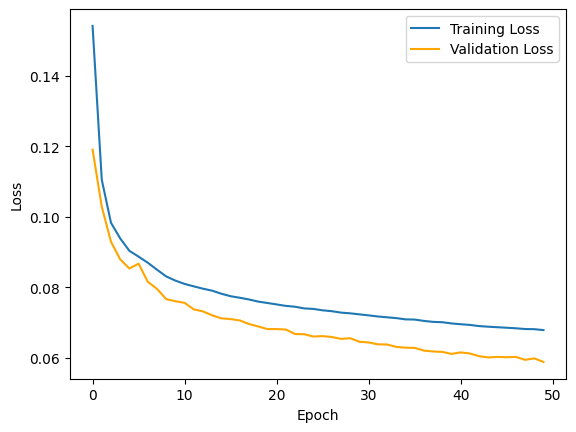

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.plot(val_losses, label='Validation Loss', color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

### Generation

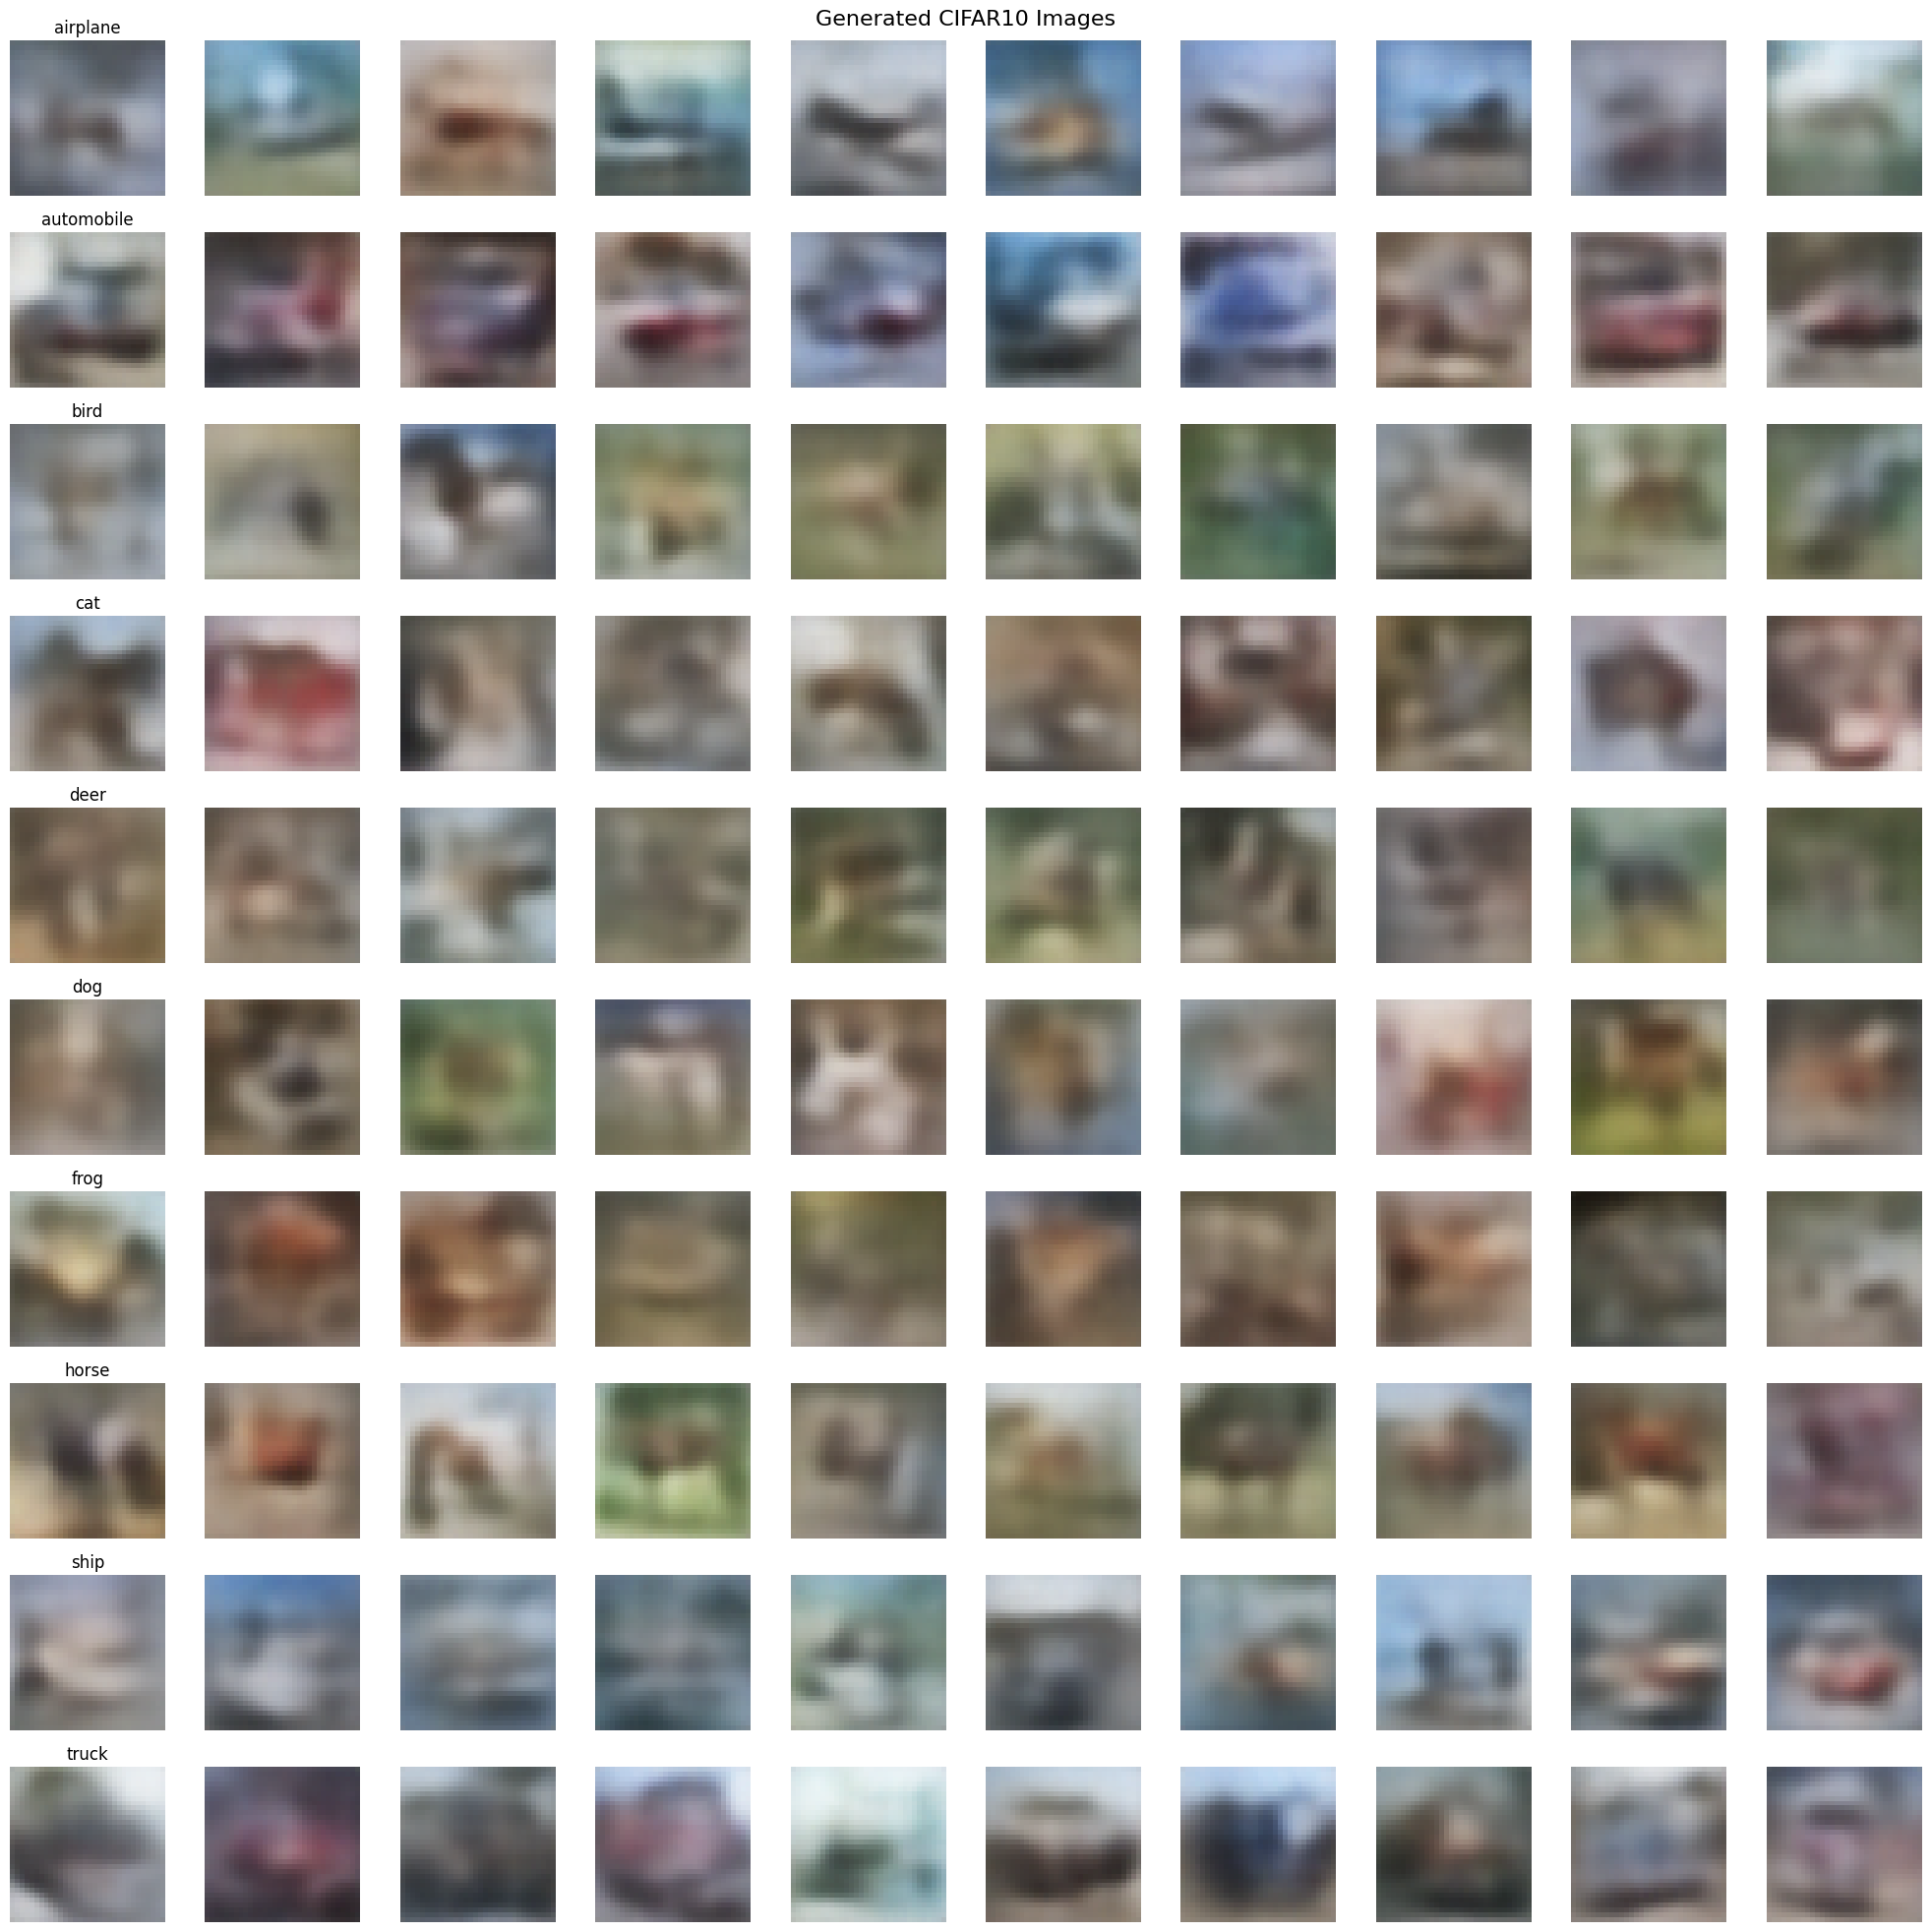

In [ ]:
def generate_cifar10_images(model, device, num_images_per_class=10):
    model.eval()

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    generated_images = {}

    with torch.no_grad():
        for class_idx, class_name in enumerate(classes):
            class_images = []

            for _ in range(num_images_per_class):
                c = F.one_hot(torch.tensor([class_idx]), num_classes=10).float().to(device)

                num_output_features = model.fc_mu[-3].out_features
                z = torch.randn(1, num_output_features).to(device)
                generated = model.decode(z, c)

                img = generated.cpu().squeeze().permute(1, 2, 0).numpy()

                img = (img + 1) / 2

                class_images.append(img)

            generated_images[class_name] = class_images

    return generated_images

def plot_generated_images(generated_images, num_images_per_class=10):
    classes = list(generated_images.keys())
    fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(20, 20))
    fig.suptitle("Generated CIFAR10 Images", fontsize=16)

    for i, class_name in enumerate(classes):
        for j in range(num_images_per_class):
            ax = axes[i, j]
            ax.imshow(generated_images[class_name][j])
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name)

    plt.tight_layout()
    plt.show()

generated_images = generate_cifar10_images(model, device)
plot_generated_images(generated_images)

### Reconstruction

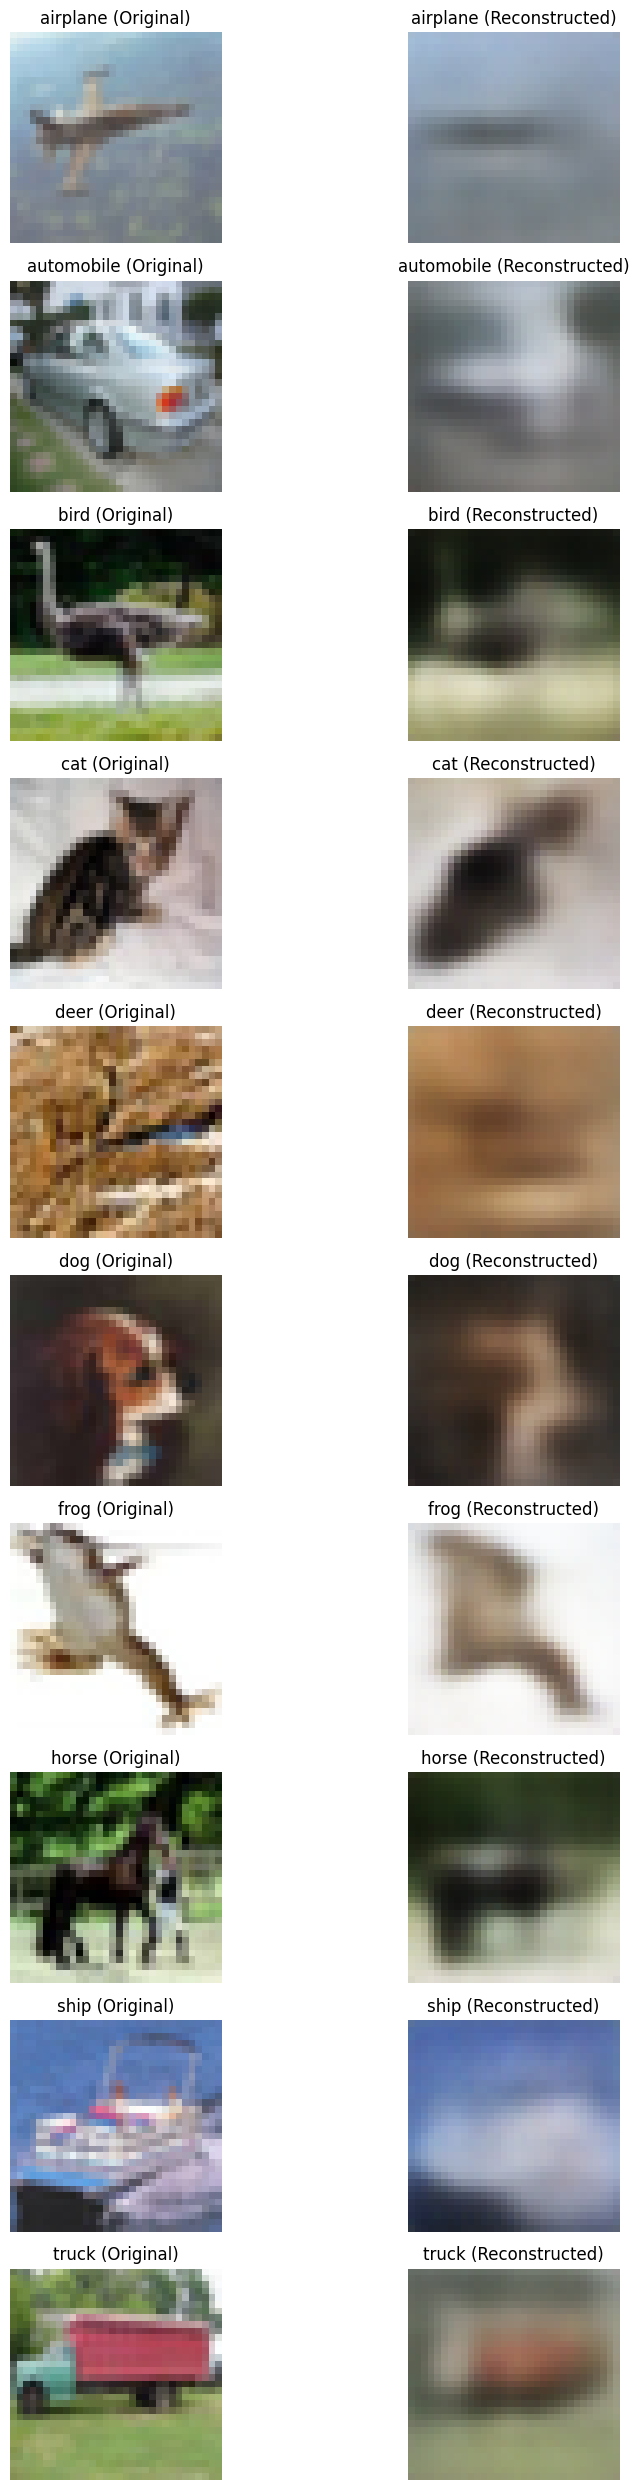

In [ ]:
def reconstruct_cifar10_images(model, device, val_loader):
    model.eval()

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    class_images = {c: None for c in classes}
    class_labels = {c: None for c in classes}

    for batch in val_loader:
        imgs, labels = batch
        for img, label in zip(imgs, labels):
            class_name = classes[label]
            if class_images[class_name] is None:
                class_images[class_name] = img
                class_labels[class_name] = label
            if all(v is not None for v in class_images.values()):
                break
        if all(v is not None for v in class_images.values()):
            break

    reconstructed_images = {}

    with torch.no_grad():
        for class_name, img in class_images.items():

            x = img.unsqueeze(0).to(device)
            c = F.one_hot(class_labels[class_name].unsqueeze(0), num_classes=10).float().to(device)


            recon, _, _ = model(x, c)

            reconstructed_images[class_name] = {
                'original': img.cpu().numpy().transpose(1, 2, 0),
                'reconstructed': recon.cpu().squeeze().permute(1, 2, 0).numpy()
            }

    return reconstructed_images

def plot_reconstructed_images(reconstructed_images):
    classes = list(reconstructed_images.keys())
    fig, axes = plt.subplots(len(classes), 2, figsize=(10, 25))


    for i, class_name in enumerate(classes):
        # Plot original image
        axes[i, 0].imshow((reconstructed_images[class_name]['original'] + 1) / 2)
        axes[i, 0].set_title(f"{class_name} (Original)")
        axes[i, 0].axis('off')

        # Plot reconstructed image
        axes[i, 1].imshow((reconstructed_images[class_name]['reconstructed'] + 1) / 2)
        axes[i, 1].set_title(f"{class_name} (Reconstructed)")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

reconstructed_images = reconstruct_cifar10_images(model, device, val_loader)
plot_reconstructed_images(reconstructed_images)

## Failed Draft
I was trying to make the model more complex but I got worse results, please just skip this attempt :) and fold the code to see the discussion.

In [ ]:
# class ImageGenerator(nn.Module):
#     def __init__(self, z_dim):
#         super(ImageGenerator, self).__init__()
#         self.z_dim = z_dim
#         self.dropout_rate = 0.1

#         def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_pool=False):
#             layers = [
#                 nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
#                 nn.BatchNorm2d(out_channels),
#                 nn.LeakyReLU(0.2)
#             ]
#             if use_pool:
#                 layers.append(nn.MaxPool2d(2, 2))
#             return nn.Sequential(*layers)

#         self.encoder = nn.Sequential(
#             conv_block(3, 32),
#             conv_block(32, 32),
#             conv_block(32, 64, use_pool=True),
#             conv_block(64, 64),
#             conv_block(64, 128, use_pool=True),
#             conv_block(128, 128),
#             conv_block(128, 256, use_pool=True),
#             conv_block(256, 256)
#         )

#         self.fc_mu = nn.Sequential(
#             nn.Linear(256 * 4 * 4 + 10, 512),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(512, z_dim),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(self.dropout_rate)
#         )

#         self.fc_logvar = nn.Sequential(
#             nn.Linear(256 * 4 * 4 + 10, 512),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(self.dropout_rate),
#             nn.Linear(512, z_dim),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(self.dropout_rate)
#         )

#         self.decoder_input = nn.Sequential(
#             nn.Linear(z_dim + 10, 256 * 4 * 4),
#             nn.Dropout(self.dropout_rate),
#             nn.ReLU()
#         )

#         def deconv_block(in_channels, out_channels, kernel_size=2, stride=2, padding=0):
#             return nn.Sequential(
#                 nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
#                 nn.BatchNorm2d(out_channels),
#                 nn.LeakyReLU(0.2)
#             )

#         self.decoder = nn.Sequential(
#             deconv_block(256, 128),
#             nn.Conv2d(128, 128, 3, 1, 1),
#             deconv_block(128, 64),
#             nn.Conv2d(64, 64, 3, 1, 1),
#             deconv_block(64, 32),
#             nn.Conv2d(32, 3, 3, 1, 1),
#             nn.LeakyReLU(0.2)
#         )

#         self.mu = None
#         self.logvar = None

#     def encode(self, x, c):
#         x = self.encoder(x)
#         x = x.view(x.size(0), -1)
#         x = torch.cat([x, c], dim=1)
#         self.mu = self.fc_mu(x)
#         self.logvar = self.fc_logvar(x)
#         return self.mu, self.logvar

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z, c):
#         z = torch.cat([z, c], dim=1)
#         x = self.decoder_input(z)
#         x = x.view(-1, 256, 4, 4)
#         x = self.decoder(x)
#         return x

#     def forward(self, x, c):
#         self.mu, self.logvar = self.encode(x, c)
#         z = self.reparameterize(self.mu, self.logvar)
#         return self.decode(z, c), self.mu, self.logvar

### Sanity check

In [ ]:
# latent_dim = 100
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# data, labels = next(iter(train_loader))
# data, labels = data.to(device), labels.to(device)
# # One-hot encode the labels
# c = torch.zeros(data.size(0), 10, device=device)
# c.scatter_(1, labels.unsqueeze(1), 1)
# model = ImageGenerator(latent_dim).to(device)
# recon_batch, mu, logvar = model(data, c)
# print(recon_batch.shape)

torch.Size([256, 3, 32, 32])


### Training loop

In [ ]:
# num_epochs = 25
# learning_rate = 1e-3
# KLD_WEIGHT = 0.00012
# optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
# # torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1, verbose='deprecated')
# lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


In [ ]:
# train_losses = []
# val_losses = []
# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for batch_idx, (imgs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
#         imgs, labels = imgs.to(device), labels.to(device)

#         c = torch.zeros(imgs.size(0), 10, device=device)
#         c.scatter_(1, labels.unsqueeze(1), 1)


#         reconstructed_imgs, mu, logvar = model(imgs, c)
#         loss = loss_fn(imgs, reconstructed_imgs, mu, logvar)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     lr_scheduler.step()

#     epoch_loss = train_loss / len(train_loader)
#     train_losses.append(epoch_loss)

#     # validation loop
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for batch_idx, (imgs, labels) in tqdm(enumerate(val_loader), total=len(val_loader)):
#             imgs, labels = imgs.to(device), labels.to(device)

#             # One-hot encode the labels
#             c = torch.zeros(imgs.size(0), 10, device=device)
#             c.scatter_(1, labels.unsqueeze(1), 1)

#             reconstructed_imgs, mu, logvar = model(imgs, c)
#             loss = loss_fn(imgs, reconstructed_imgs, mu, logvar)
#             val_loss += loss.item()

#     epoch_val_loss = val_loss / len(val_loader)
#     val_losses.append(epoch_val_loss)

#     print(f"\nEpoch: {epoch+1}/{num_epochs} Training loss: {epoch_loss:.4f} \t Validation loss: {epoch_val_loss}")

100%|██████████| 40/40 [00:04<00:00,  9.71it/s]



Epoch: 1/25 Training loss: 0.1077 	 Validation loss: 0.09992703646421433


100%|██████████| 40/40 [00:03<00:00, 12.10it/s]



Epoch: 2/25 Training loss: 0.0994 	 Validation loss: 0.0934146048501134


100%|██████████| 40/40 [00:04<00:00,  9.62it/s]



Epoch: 3/25 Training loss: 0.0972 	 Validation loss: 0.09099793080240488


100%|██████████| 40/40 [00:03<00:00, 12.51it/s]



Epoch: 4/25 Training loss: 0.0956 	 Validation loss: 0.08946739695966244


100%|██████████| 40/40 [00:03<00:00, 10.89it/s]



Epoch: 5/25 Training loss: 0.0941 	 Validation loss: 0.08795368149876595


100%|██████████| 40/40 [00:03<00:00, 12.50it/s]



Epoch: 6/25 Training loss: 0.0926 	 Validation loss: 0.08568498883396387


100%|██████████| 40/40 [00:03<00:00, 12.78it/s]



Epoch: 7/25 Training loss: 0.0916 	 Validation loss: 0.08513061348348856


100%|██████████| 40/40 [00:03<00:00, 12.02it/s]



Epoch: 8/25 Training loss: 0.0909 	 Validation loss: 0.08450394961982965


100%|██████████| 40/40 [00:03<00:00, 12.16it/s]



Epoch: 9/25 Training loss: 0.0904 	 Validation loss: 0.08392487466335297


100%|██████████| 40/40 [00:03<00:00, 10.44it/s]



Epoch: 10/25 Training loss: 0.0899 	 Validation loss: 0.08417902402579784


100%|██████████| 40/40 [00:03<00:00, 12.82it/s]



Epoch: 11/25 Training loss: 0.0895 	 Validation loss: 0.08311903998255729


100%|██████████| 40/40 [00:04<00:00,  9.82it/s]



Epoch: 12/25 Training loss: 0.0891 	 Validation loss: 0.08235290311276913


100%|██████████| 40/40 [00:03<00:00, 12.31it/s]



Epoch: 13/25 Training loss: 0.0887 	 Validation loss: 0.0821438930928707


100%|██████████| 40/40 [00:04<00:00,  9.92it/s]



Epoch: 14/25 Training loss: 0.0885 	 Validation loss: 0.08178689330816269


100%|██████████| 40/40 [00:03<00:00, 12.70it/s]



Epoch: 15/25 Training loss: 0.0883 	 Validation loss: 0.08188506234437228


100%|██████████| 40/40 [00:03<00:00, 11.54it/s]



Epoch: 16/25 Training loss: 0.0881 	 Validation loss: 0.08135087303817272


100%|██████████| 40/40 [00:03<00:00, 12.55it/s]



Epoch: 17/25 Training loss: 0.0879 	 Validation loss: 0.08112549986690283


100%|██████████| 40/40 [00:03<00:00, 12.20it/s]



Epoch: 18/25 Training loss: 0.0878 	 Validation loss: 0.08110992051661015


100%|██████████| 40/40 [00:03<00:00, 12.28it/s]



Epoch: 19/25 Training loss: 0.0877 	 Validation loss: 0.08093697056174279


100%|██████████| 40/40 [00:03<00:00, 12.12it/s]



Epoch: 20/25 Training loss: 0.0876 	 Validation loss: 0.08089184910058975


100%|██████████| 40/40 [00:03<00:00, 11.60it/s]



Epoch: 21/25 Training loss: 0.0876 	 Validation loss: 0.08085414525121451


100%|██████████| 40/40 [00:03<00:00, 12.68it/s]



Epoch: 22/25 Training loss: 0.0876 	 Validation loss: 0.08091634791344404


100%|██████████| 40/40 [00:04<00:00,  9.63it/s]



Epoch: 23/25 Training loss: 0.0875 	 Validation loss: 0.08083846773952245


100%|██████████| 40/40 [00:03<00:00, 12.50it/s]



Epoch: 24/25 Training loss: 0.0875 	 Validation loss: 0.08078906126320362


100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


Epoch: 25/25 Training loss: 0.0874 	 Validation loss: 0.08069757223129273


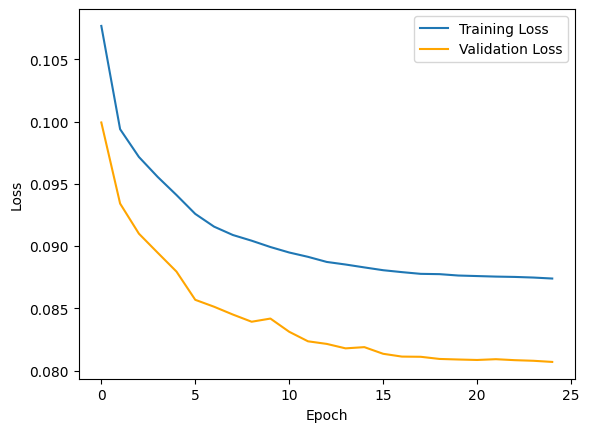

In [ ]:
# plt.plot(train_losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.plot(val_losses, label='Validation Loss', color="orange")
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

### Evaluation

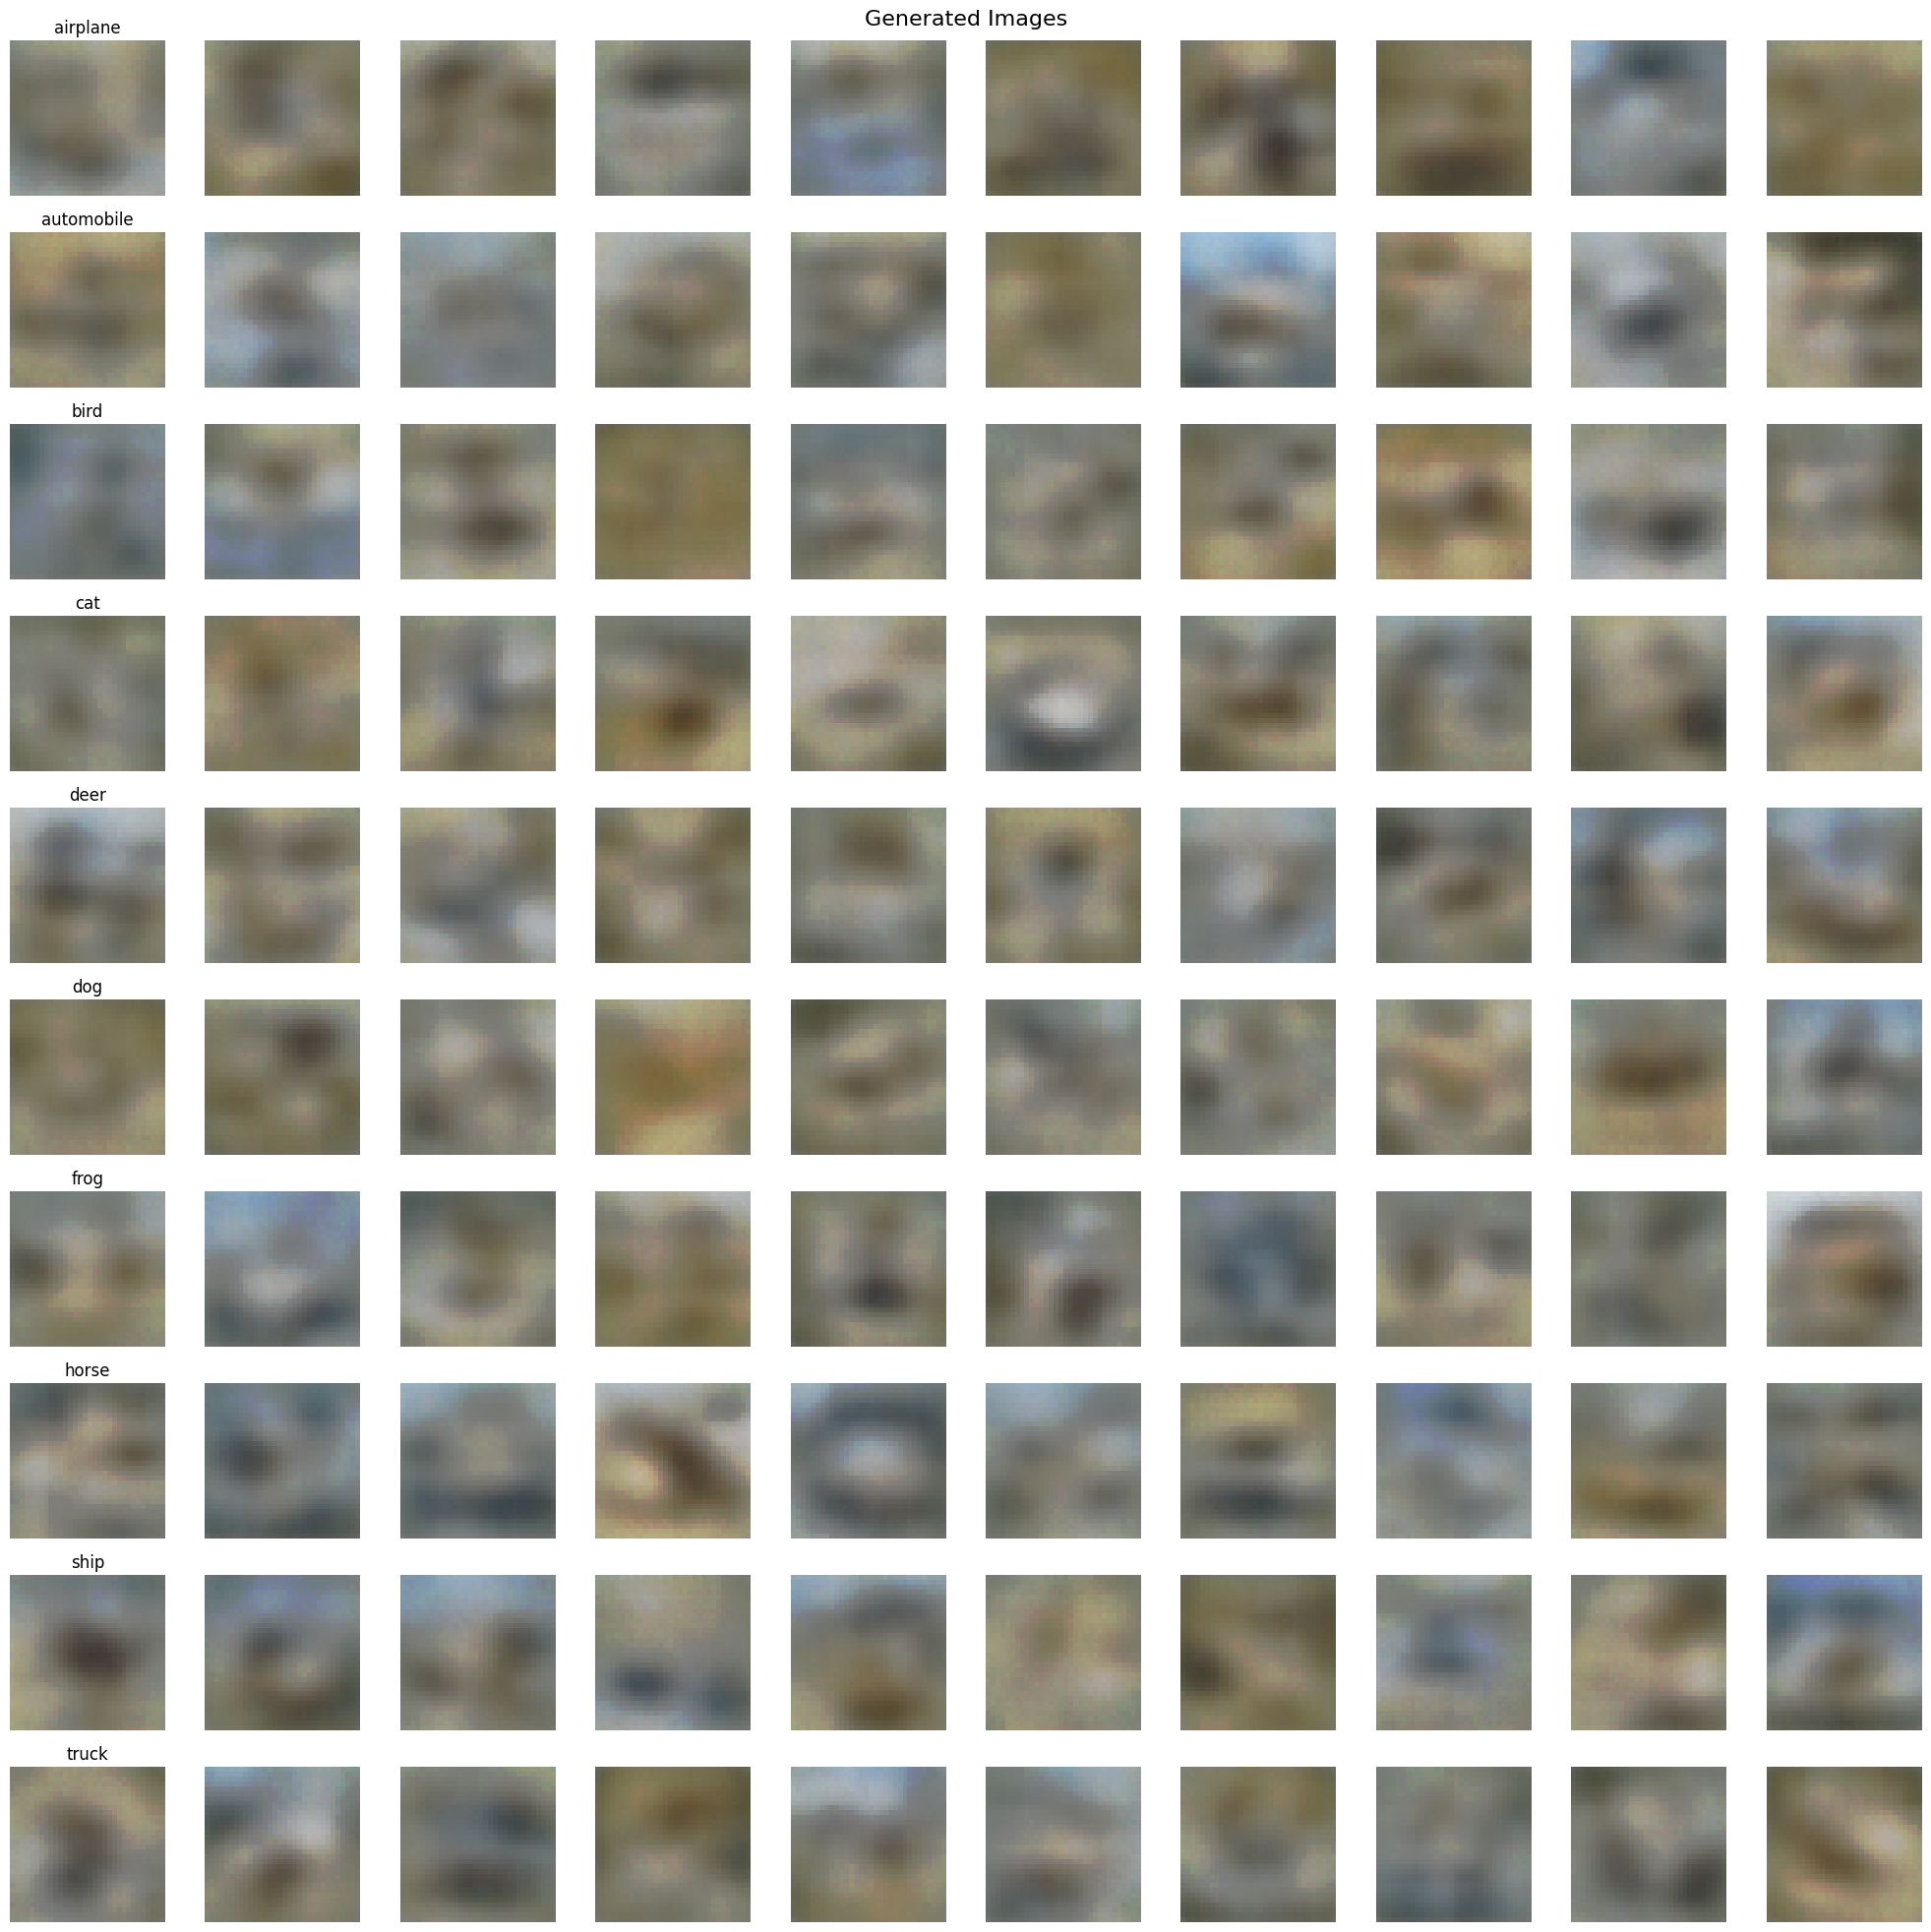

In [ ]:
# generated_images = generate_cifar10_images(model, device)
# plot_generated_images(generated_images)

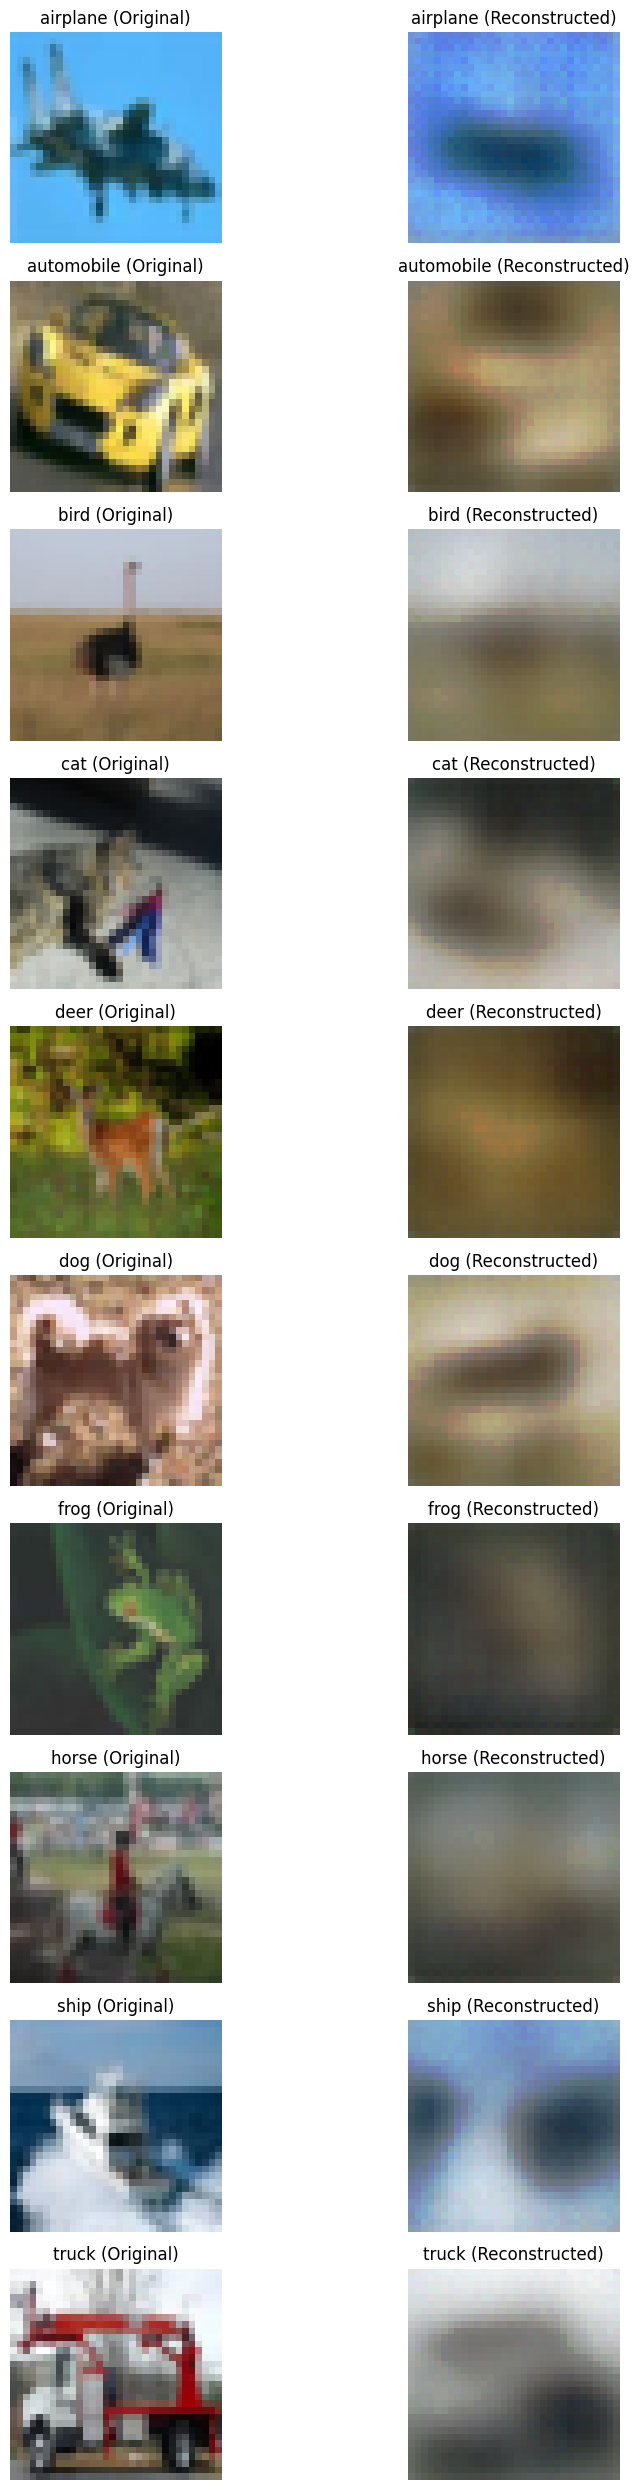

In [ ]:
# # showing a reconstruction example
# reconstructed_images = reconstruct_cifar10_images(model, device, val_loader)
# plot_reconstructed_images(reconstructed_images)


# Discussion

***What I have tried:***

I have manipulated my model architecture extensively and found that when I used more than one linear layer for the mu and logvar, my model did not improve. In fact, the results were worse, which is counterintuitive to me. I think the increased complexity might have made the model harder to train because the complex model's losses decreased more slowly than the simple one, and I think with more epochs, the model might eventually give better results than the simpler model.

For the draft model, I have tried a deeper archeticture and the results were way worse and again I think the increased complexity might have made the model harder to train.



***What I haven't tried and that could help:***

The way I am feeding the label to the model may not be optimal. I concatenate the one hot encoded class with the linear layers of mu and logvar in the encoder and with the z before first linear layer of the decoder. I feel this way is not emphsizing the class enough. I have 2 better ways in mind that if I have time I would consider trying. First, concatenate the one hot encoded class with the input (image) of the encoder as well as mu and logvar. Second, concatenate the one hot encoded class with the output of the last conv layer in the encoder and then pass it to a couple linear layers before mu and logvar.